# Clustering Chicago Communities and Inspect Resident Characteristics of Each Cluster (in process)

### Introduction

#### Backgroud
[“The place that you live shapes so profoundly all aspects of your life,”](https://chicago.cbslocal.com/2019/02/11/race-segregation-chicago-neighborhoods/) said Maria Krysan, professor of sociology at the University of Illinois at Chicago.    

Chicago is known for the segregation of its citizens. People of different racial, economic and/or social status cluster into different communities, living starkly different lives. This project looks into one specific aspect of the life of Chicago residents: their economic circumstances, via shopping options in these residents’ respective living spaces.   

#### Problem
It is reasonable to assume that economic segregation can be reflected in people’s daily purchases -- in other words, their options on where to spend money on food, retail goods, activities, etc. __This project aims to examine if buying options in certain communities are similar if the community residents’ respective social, economic, and racial/ethnic traits are similar.__ It does not assume or attempts to deduct a causal relationship between common shopping options and economic segregation, but simply shows that some correlation exists in between the two.  

The first step of this project is to put cluster the 77 Chicago community areas based on the top 10 most commonly occurred venue types in each area. The second step is to closely examine the characteristics of residents in each community, and to see if communities with similar residents are put into the same cluster in the previous step.    
In the second step, a classification model will be developed in which cluster labels generated in step 1 will be treated as a response variable, while resident features in each community, such as *median per capita income*, _race composition_, *age composition*, etc., will serve as independent variables. The model will be used to test correlations between resident features and the cluster labels ---- if correlation is strong, resident features will yield a higher accuracy rate when predicting the cluster labels for the neighborhoods. 

#### Interests
This can be a prelimentary step in the study of socioeconomic segregation in the U.S. urban areas. The result of this study can be of interests to scholars, policymakers, social workers and/or activists, as well as those who are directly affected by such segregation. 

In [9]:
# Install and import all necessary stuff
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import bs4
from bs4 import BeautifulSoup

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

# KMeans clustering package
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Seaborn
import seaborn as sns

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


In [10]:
chi_df = pd.read_csv('censusData.csv')
chi_df.columns = chi_df.columns.str.replace(' ', '_')
chi_df.columns = [x.lower() for x in chi_df.columns]
chi_df.head()

# Make minor change in community names, change wrong spellings
chi_df["community_area_name"] = chi_df["community_area_name"].apply(lambda x: "{}, {}, {}".format(x, "Chicago", "IL"))
chi_df.community_area_name[chi_df.community_area_name == 'Montclaire, Chicago, IL'] = 'Montclare, Chicago, IL'
chi_df.community_area_name[chi_df.community_area_name == 'Washington Height, Chicago, IL'] = 'Washington Heights, Chicago, IL'

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [11]:
# Define a function that gets the coordinates of a list of places 
def getCoords(names):
    coords = []
    for name in names:
        address = name
        geolocator = Nominatim(user_agent = "chi_explorer")
        try:
            location = geolocator.geocode(address)
            latitude = location.latitude
            longitude = location.longitude
            str = [latitude, longitude]
            coords.append(str)
            
        except: 
            str = 'N/A'
            coords.append([str])
            print(name + " can't be processed")
            
    return coords

In [12]:
coordinates = getCoords(chi_df['community_area_name'])
coordinates = pd.DataFrame(coordinates)
chi_df = pd.concat([chi_df, coordinates], axis = 1)
chi_df = chi_df[['community_area_name', 0, 1]]
chi_df.rename(columns = {0 : "Latitude", 1 : "Longitude"}, inplace = True)

In [13]:
#chi_df.Latitude[chi_df.community_area_name == 'Grand Boulevard, Chicago, IL'] = 41.8131
#chi_df.Longitude[chi_df.community_area_name == 'Grand Boulevard, Chicago, IL'] = -87.6178
chi_df.Latitude[chi_df.community_area_name == 'Lincoln Square, Chicago, IL'] = 41.9687
chi_df.Longitude[chi_df.community_area_name == 'Lincoln Square, Chicago, IL'] = -87.6890
chi_df.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,community_area_name,Latitude,Longitude
0,"Rogers Park, Chicago, IL",42.010531,-87.670748
1,"West Ridge, Chicago, IL",42.003548,-87.696243
2,"Uptown, Chicago, IL",41.966630,-87.655546
3,"Lincoln Square, Chicago, IL",41.968700,-87.689000
4,"North Center, Chicago, IL",41.956107,-87.679160


In [14]:
# Get the coordinats of Chicago
address = 'Lincoln Square, Chicago, IL'
geolocator = Nominatim(user_agent = "chi_explorer")
location = geolocator.geocode(address)
chi_lat = location.latitude
chi_lng = location.longitude
print(chi_lat, chi_lng)

42.2669968 -71.7984322


In [15]:
# Get the coordinats of Chicago
address = 'Chicago, IL'
geolocator = Nominatim(user_agent = "chi_explorer")
location = geolocator.geocode(address)
chi_lat = location.latitude
chi_lng = location.longitude
print(chi_lat, chi_lng)

41.8755616 -87.6244212


In [16]:
# Create map of Chicago using latitude and longitude values
map_chicago = folium.Map(location = [chi_lat, chi_lng], zoom_start = 10)

# Add markers to the map
for lat, lng, comm in zip(chi_df['Latitude'], chi_df['Longitude'], chi_df['community_area_name']):
    label = comm
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 4,
        popup = label,
        color = 'darkblue',
        fill = True,
        fill_color = '#ffffff',
        parse_html = False).add_to(map_chicago)  
    
map_chicago

In [17]:
# Set up Four Square credentials 
CLIENT_ID = 'DU1RZNIYZKMR4ND3KK4F3FASRDB1GJGKM0TYVLLLF0NFQKZU' # Foursquare ID
CLIENT_SECRET = '30BO30FW3YDGZM0BQO0VV0VR0WDPNYESACKI4UFCQD1IAPX4' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: DU1RZNIYZKMR4ND3KK4F3FASRDB1GJGKM0TYVLLLF0NFQKZU
CLIENT_SECRET:30BO30FW3YDGZM0BQO0VV0VR0WDPNYESACKI4UFCQD1IAPX4


In [18]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

It is hard to determine the radius for searching. Some of

In [20]:
def getNearbyVenues(names, latitudes, longitudes):
    radius = 2500
    LIMIT = 100
    urlformat = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'
    
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = urlformat.format(CLIENT_ID, 
                               CLIENT_SECRET, 
                               VERSION, 
                               lat, 
                               lng, 
                               radius, 
                               LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Community', 
                  'Community Latitude', 
                  'Community Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
chicago_venues = getNearbyVenues(names = chi_df['community_area_name'],
                                 latitudes = chi_df['Latitude'],
                                 longitudes = chi_df['Longitude']
                                )

In [ ]:
# Count number of venues in each neighborhood, sort the result ascendingly. 
num = pd.DataFrame(chicago_venues.groupby('Community').count()['Venue Category']).sort_values(by = 'Venue Category').reset_index()
num

In [ ]:
# One hot encoding
chicago_onehot = pd.get_dummies(chicago_venues['Venue Category'], prefix="", prefix_sep="")

# Move neighborhood column to the first column
fixed_columns = [chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])
chicago_onehot = chicago_onehot[fixed_columns]
chicago_onehot = chicago_onehot.drop('Neighborhood', axis=1)  

In [ ]:
# Put Neighbourhood names back to the one-hot-coded dataframe
names = pd.DataFrame(chicago_venues['Community'])
chicago = pd.concat([names, chicago_onehot], axis=1)

# Get the frenquency of occurances of each type of venue for each neighborhood
chicago = chicago.groupby('Community').mean().reset_index()
chicago.head()

In [ ]:
# Define a function that returns the most common venue of a community
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Community']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
chicago_venues_sorted = pd.DataFrame(columns = columns)
chicago_venues_sorted['Community'] = chicago['Community']

for ind in np.arange(chicago.shape[0]):
    chicago_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago.iloc[ind, :], num_top_venues)

chicago_venues_sorted.head()

In [ ]:
# Set number of clusters
kclusters = 5

chicago_clustering = chicago.drop('Community', axis = 1)

# Run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(chicago_clustering)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

In [ ]:
# Add clustering labels
chicago_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
chicago_venues_sorted.head()

# Merge toronto_grouped with chicago data to add latitude/longitude for each community
chi_df.rename(columns = {'community_area_name':'Community'}, inplace = True)
chicago_merged = chi_df
chicago_merged = chicago_merged.join(chicago_venues_sorted.set_index('Community'), on = 'Community').dropna(axis = 0)
# For some reason the labels changed to floats after the join. Quick fix!
chicago_merged['Cluster Labels'] = chicago_merged['Cluster Labels'].astype(int)
chicago_merged.head()

In [ ]:
# Create map
map_clusters = folium.Map(location=[chi_lat, chi_lng], zoom_start=11)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_merged['Latitude'], chicago_merged['Longitude'], chicago_merged['Community'], chicago_merged['Cluster Labels']):
    label = folium.Popup(poi, parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [22]:
# Cluster 0
chicago_merged.loc[chicago_merged['Cluster Labels'] == 0, chicago_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

NameError: name 'chicago_merged' is not defined

### 2. Try To Find Why Different Venues are common in Different Communities

In [180]:
# Import necessary packages
import sklearn
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn import metrics

!conda install -c conda-forge pydotplus -y
!conda install -c conda-forge python-graphviz -y

from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

Solving environment: done

## Package Plan ##

  environment location: /anaconda3

  added / updated specs:
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.7.11               |           py37_0         3.0 MB  conda-forge
    graphviz-2.40.1            |       hefbbd9a_2         6.7 MB
    pydotplus-2.0.2            |     pyhd1c1de3_3          23 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         9.7 MB

The following NEW packages will be INSTALLED:

  graphviz           pkgs/main/osx-64::graphviz-2.40.1-hefbbd9a_2
  pydotplus          conda-forge/noarch::pydotplus-2.0.2-pyhd1c1de3_3

The following packages will be UPDATED:

  conda                                       4.7.10-py37_0 --> 4.7.11-py37_0



pydotplus-2.0.2      | 23 KB     | #####################################

First, I find some variables to describe citizens in different neighborhoods. They come from various sources, so I have to do a little bit of data wrangling to get my desired dataframe. In total, I chose: 
1. per capita income
2. gender composition
3. age composition (in particular, % of residents who are under 18 or over 64)
4. ethnic/racial composition (which may lead to very different demand in venues, I guess)
5. people's choice of transportation

In [80]:
# Per Capita income and age data from the 2017 U.S. census data.
chi_census = pd.read_csv('censusData.csv')
chi_census = chi_census[["COMMUNITY AREA NAME", "PER CAPITA INCOME ", "PERCENT AGED UNDER 18 OR OVER 64"]]
chi_census.rename(columns = {"COMMUNITY AREA NAME":"GEOG"}, inplace = True)

# Make amendments on false spellings
chi_census.GEOG[chi_census.GEOG == 'Montclaire'] = 'Montclare'
chi_census.GEOG[chi_census.GEOG == 'Washington Height'] = 'Washington Heights'
chi_census.GEOG[chi_census.GEOG == 'Loop'] = 'The Loop'
chi_census.GEOG[chi_census.GEOG == 'Humboldt park'] = 'Humboldt Park'
chi_census.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

,GEOG,PER CAPITA INCOME,PERCENT AGED UNDER 18 OR OVER 64
0,Rogers Park,23939,27.5
1,West Ridge,23040,38.5
2,Uptown,35787,22.2
3,Lincoln Square,37524,25.5
4,North Center,57123,26.2


In [81]:
# Other data from CMap Data Hub
chi_raw = pd.read_csv('ReferenceCCAProfiles20132017.csv')


In [82]:
# Race/ethnicity composition data
chi_eth = chi_raw[['GEOG', 'TOT_POP', 'WHITE', 'HISP', 'BLACK', 'ASIAN', 'OTHER']]

# Transform #people to percentage 
for col in chi_eth.columns[2:]: 
    chi_eth[col] = round(chi_eth[col]/chi_eth['TOT_POP'], 2)

chi = pd.merge(chi_eth, chi_census, how = 'outer', on = 'GEOG')
chi

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,GEOG,TOT_POP,WHITE,HISP,BLACK,ASIAN,OTHER,PER CAPITA INCOME,PERCENT AGED UNDER 18 OR OVER 64
0,Albany Park,51992,0.30,0.48,0.05,0.14,0.03,21323,32.0
1,Archer Heights,13142,0.17,0.77,0.01,0.04,0.00,16134,39.2
2,Armour Square,13455,0.13,0.04,0.09,0.73,0.01,16148,38.3
3,Ashburn,43792,0.11,0.39,0.48,0.01,0.02,23482,36.9
4,Auburn Gresham,46278,0.01,0.02,0.96,0.00,0.01,15528,41.9
5,Austin,95260,0.05,0.13,0.81,0.01,0.01,15957,37.9
6,Avalon Park,9985,0.01,0.01,0.97,0.00,0.01,24454,39.3
7,Avondale,37368,0.34,0.58,0.02,0.04,0.02,20039,31.0
8,Belmont Cragin,79910,0.13,0.81,0.03,0.02,0.01,15461,37.3
9,Beverly,20822,0.58,0.05,0.34,0.01,0.03,39523,40.5


In [65]:
# Transportation styles data 
chi_trans = chi_raw[['GEOG', 'TOT_POP', 'WORK_AT_HOME', 'TOT_COMM', 'DROVE_AL', 'CARPOOL', 'TRANSIT', 'WALK_BIKE', 'COMM_OTHER']]
# Transform #people to percentage 
for col in chi_trans.columns[2:]: 
    chi_trans[col] = round(chi_trans[col]/chi_trans['TOT_POP'], 2)

#chi = pd.merge(chi, chi_trans, on = 'GEOG')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Next, I add in some variables that characterize each community area. I chose: 
1. Median cost of transportation
2. park availability (open space access per 1000 residents)

In [83]:
chi.rename(columns = {'GEOG' : 'Community'}, inplace = True)
chi.shape

(77, 9)

In [92]:
chi_cluster = chicago_merged[['Community', 'Cluster Labels']]
# Quick fix on Community Names
chi_cluster['Community'] = chi_cluster['Community'].str.split(', ').str.get(0)
chi_cluster.Community[chi_cluster.Community == 'Montclaire'] = 'Montclare'
chi_cluster.Community[chi_cluster.Community == 'Washington Height'] = 'Washington Heights'
chi_cluster.Community[chi_cluster.Community == 'Loop'] = 'The Loop'
chi_cluster.Community[chi_cluster.Community == 'Humboldt park'] = 'Humboldt Park'
chi_cluster.head()


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view

,Community,Cluster Labels
0,Rogers Park,1
1,West Ridge,1
2,Uptown,1
3,Lincoln Square,1
4,North Center,1


In [120]:
chi_final = pd.merge(chi_cluster, chi, on = 'Community')
chi_final = chi_final.sort_values('Cluster Labels')
chi_final.insert(0, 'ID', range(1, len(chi_final)+1))
chi_final.head()

,ID,Community,Cluster Labels,TOT_POP,WHITE,HISP,BLACK,ASIAN,OTHER,PER CAPITA INCOME,PERCENT AGED UNDER 18 OR OVER 64
44,1,Avalon Park,0,9985,0.01,0.01,0.97,0.0,0.01,24454,39.3
43,2,Chatham,0,31120,0.02,0.01,0.96,0.0,0.01,18881,40.3
46,3,Burnside,0,2254,0.00,0.01,0.97,0.0,0.01,12515,42.7
47,4,Calumet Heights,0,13188,0.02,0.03,0.94,0.0,0.01,28887,44.0
48,5,Roseland,0,42433,0.01,0.01,0.96,0.0,0.01,17949,41.2


In [106]:
cluster1 = chi_final.loc[chi_final['Cluster Labels'] == 0]
cluster1 = cluster1[['Community', 'PER CAPITA INCOME ']]

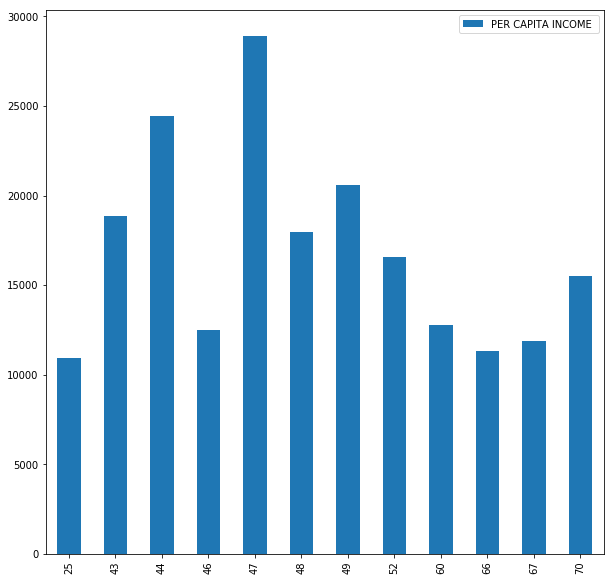

In [127]:
cluster1.plot(kind='bar', figsize=(10, 10))

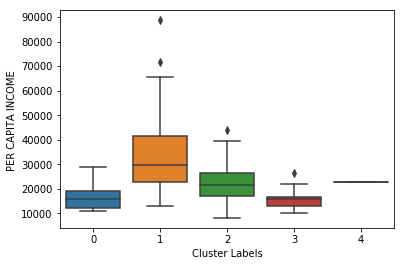

In [135]:
# Quick look at the income distribution in each group
sns.boxplot(x = "Cluster Labels", y = 'PER CAPITA INCOME ', data = chi_final)

Visually, we can say that cluster 1 has relatively high per capita income among all 5 groups, with a couple of outliers on the upper side. Cluster 0 and 3 have significantly lower income among the four clusters. 

In [1]:
# Quick look at the racial distributions in each group
#sns.boxplot(x = "Cluster Labels", y = 'WHITE', data = chi_final)
#sns.boxplot(x = "Cluster Labels", y = 'HISP', data = chi_final)
#sns.boxplot(x = "Cluster Labels", y = 'BLACK', data = chi_final)
sns.barplot(x = "ID", y = 'HISP', hue = 'Cluster Labels', data = chi_final)
palette=dict(setosa="#9b59b6", virginica="#3498db", versicolor="#95a5a6")
 
sns.plt.show()

NameError: name 'sns' is not defined

Now, we can see that ethnic compositions are pretty distinct among the four groups. Let's see if these features can really help us determine the clusters.

In [163]:
features = ['WHITE', 'HISP', 'BLACK', 'ASIAN', 'PER CAPITA INCOME ', 'PERCENT AGED UNDER 18 OR OVER 64']
x = chi_final[features]
y = chi_final['Cluster Labels'].values

In [164]:
x = preprocessing.StandardScaler().fit(x).transform(x)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [166]:
# Split the dataset into 80% for training and 20% for testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)
print ('Train set:', x_train.shape[0],  y_train.shape[0])
print ('Test set:', x_test.shape[0],  y_test.shape[0])

Train set: 61 61
Test set: 16 16


In [179]:
# Make a decision tree object, then fit the model 
chiTree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
chiTree.fit(x_train, y_train) # fitting the data
    
# Predict the model, show accuracy score
yHat = chiTree.predict(x_test)
acc_score = metrics.accuracy_score(y_test, yHat)

acc_score

0.75